# Self-Driving Car Engineer Nanodegree


---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


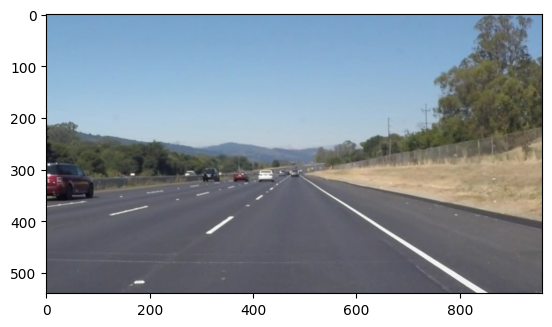

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    # Easy Version
    # for line in lines:
    #     for x1,y1,x2,y2 in line:
    #         cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    left_lane = []
    right_lane =[]

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 - x1 != 0:
                slope = (y2 - y1) / (x2 - x1)
            else:
                continue
        if abs(slope) > 0.5:
            if slope < 0:
                left_lane.append(line)
            else:
                right_lane.append(line)
    

    left_x = []
    left_y = []
    right_x = []
    right_y = []

    for left in left_lane:
        x1, y1, x2, y2 = left[0]
        left_x.append(x1)
        left_x.append(x2)
        left_y.append(y1)
        left_y.append(y2)
    

    for right in right_lane:
        x1, y1, x2, y2 = right[0]
        right_x.append(x1)
        right_x.append(x2)
        right_y.append(y1)
        right_y.append(y2)
    
    slopeX, interceptX = np.polyfit(left_x, left_y, 1)
    y_low, y_high = 320, 540 
    x_low_left, x_high_left = (320 - interceptX) / slopeX, (540 - interceptX) / slopeX
    
    cv2.line(img, (int(x_low_left), int(y_low)), (int(x_high_left), int(y_high)), color, thickness)

    slopeY, interceptY = np.polyfit(right_x, right_y, 1)
    y_low, y_high = 320, 540 
    x_low_right, x_high_right = (320 - interceptY) / slopeY, (540 - interceptY) / slopeY
    
    cv2.line(img, (int(x_low_right), int(y_low)), (int(x_high_right), int(y_high)), color, thickness)



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)    
                

## Test Images



In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



In [25]:
def img_process(image):
    # 1. Color threshoding
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([179, 20, 255])
    mask_white = cv2.inRange(hsv_image, lower_white, upper_white)

    lower_yellow = np.array([15, 80, 100])
    upper_yellow = np.array([55, 255, 255])
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)


    # Display two masked pictures together
    # plt.subplot(1, 2, 1)
    # plt.imshow(mask_yellow, cmap="gray")
    # plt.subplot(1, 2, 2)
    # plt.imshow(mask_white, cmap="gray")

    # Overlap the two images
    mask_hsv = cv2.bitwise_or(mask_yellow, mask_white)
    threshold_img = cv2.bitwise_and(image, image, mask=mask_hsv)
    output = cv2.cvtColor(threshold_img, cv2.COLOR_BGR2RGB)
    # cv2.imwrite("writeup_1.jpg", output)
    # plt.imshow(threshold_img)
    

    # 2. Grayscale
    gray_img = grayscale(threshold_img)

    # Apply Guassian Smoothing
    smooth_pic = gaussian_blur(gray_img, 5)
    # cv2.imwrite("writeup_2.jpg", smooth_pic)
    # plt.imshow(smooth_pic, cmap="gray")

    # 3. Canny Edge Detector
    canny_pic = canny(smooth_pic, 0, 100)
    # cv2.imwrite("writeup_3.jpg", canny_pic)
    # plt.imshow(canny_pic, cmap="gray")

    # 4. Region of interest selection
    # print(image.shape)
    region = np.array([[100, 540], [900, 540], [500, 320], [400, 320]])
    # img = np.zeros([560, 960],dtype=np.uint8)
    # cv2.fillPoly(img, [region], 255)
    rol_pic = region_of_interest(canny_pic, [region])
    # cv2.imwrite("writeup_4.jpg", rol_pic)
    # plt.imshow(rol_pic, cmap="gray")

    # 5. Line segment detection
    lines = hough_lines(rol_pic, 2, np.pi/180, 20, 10, 20)
    # cv2.imwrite("writeup_5.jpg", lines)
    # plt.imshow(lines)

    # 6. Line fitting
    weighted_line = weighted_img(lines, image.astype('uint8'))
    # plt.imshow(weighted_line)

    return weighted_line


True

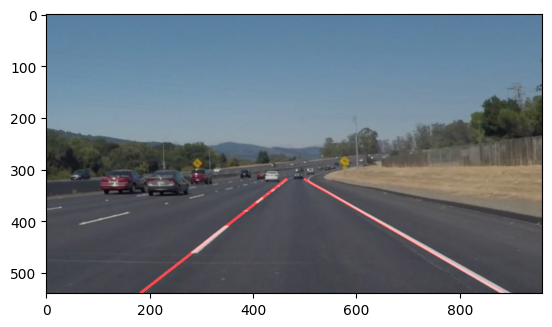

In [26]:
# Photo 1
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(img_process(image))
output = cv2.cvtColor(img_process(image), cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_out/solidWhiteCurve.jpg", output)

True

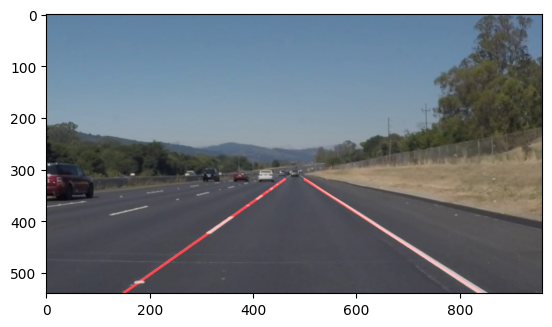

In [27]:
# Photo 2
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img_process(image))
output = cv2.cvtColor(img_process(image), cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_out/solidWhiteRight.jpg", output)

True

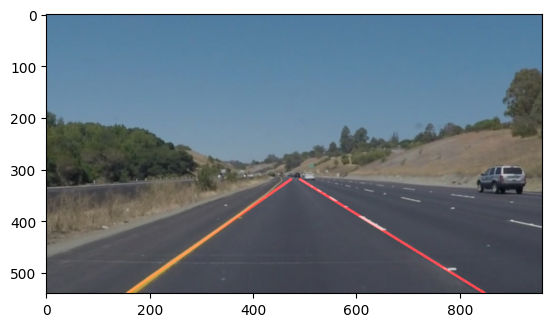

In [28]:
# Photo 3
image = mpimg.imread('test_images/solidYellowCurve.jpg')
plt.imshow(img_process(image))
output = cv2.cvtColor(img_process(image), cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_out/solidYellowCurve.jpg", output)

True

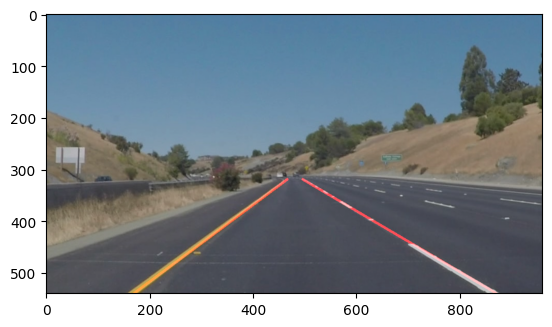

In [29]:
# Photo 4
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(img_process(image))
output = cv2.cvtColor(img_process(image), cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_out/solidYellowCurve2.jpg", output)

True

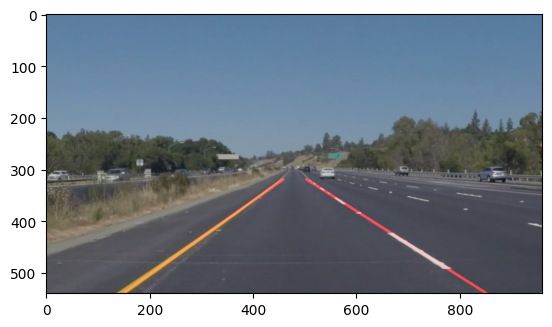

In [30]:
# Photo 5
image = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(img_process(image))
output = cv2.cvtColor(img_process(image), cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_out/solidYellowLeft.jpg", output)

True

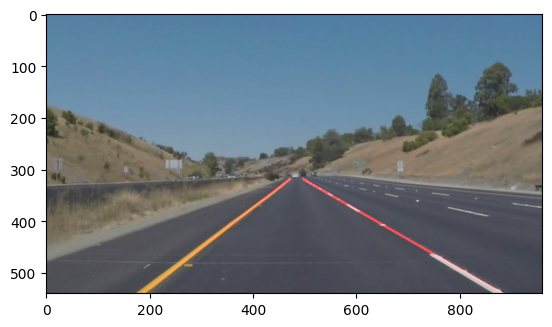

In [31]:
# Photo 6
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(img_process(image))
output = cv2.cvtColor(img_process(image), cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_out/whiteCarLaneSwitch.jpg", output)

## Test on Videos

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [73]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = img_process(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [74]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 594 ms
Wall time: 2.83 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: total: 2.61 s
Wall time: 8.12 s


In [70]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))